# Model Insights Tutorial

Select [Steps](#steps) to skip the introduction and jump right into the code sample.

## Introduction

The Model Insights feature lets you monitor how the environment that your model operates within changes in ways that affect the model's predictions.  This allows you to intervene (aka retrain a model) in an efficient and timely manner. Changes in the inputs, **data drift**, can occur due to errors in the data processing pipeline or due to changes in the environment such as user behavior.

The validation framework performs per inference range checks with count frequency based thresholds for alerts and is ideal for catching many errors in input and output data.

In complement to the validation framework, model insights examines the distribution of data within a specified window of time, and compares it to a baseline for a given pipeline. It can detect situations where values are still within the expected range, but the distribution has shifted. 

For example, a model that predicts housing prices you might expect the predictions to be between \\$200,000 and \\$1,000,000 with a distribution centered around \\$400,000. If your model suddenly starts predicting prices centered around \\$250,000 or \\$750,000, the predictions may still be within the expected range but the shift may signal something has changed that should be investigated.

Ideally we'd also monitor the _quality_ of the predictions, aka **concept drift**. However this can be difficult as true labels are often not available or are severely delayed in practice. That is there may be a significant lag between the time the prediction is made and the true (sale price) value is observed.

Consequently, model insights uses data drift detection techniques on both inputs and outputs to detect changes in the distributions of the data.

There are many useful statistical tests for calculating the difference between distributions; however, they typically require assumptions about the underlying distributions or confusing and expensive calculations. We've implemented a data drift framework that is easy to understand, fast to compute, runs in an automated fashion and is extensible to many specific use cases.

The methodology currently revolves around calculating the specific percentile-based bins of the baseline distribution and measuring how future distributions fall into these bins. This approach is both visually intuitive and supports an easy to calculate difference score between distributions. Users can tune the scoring mechanism to emphasize different regions of the distribution: for example, you may only care if there is a change in the top 20th percentile of the distribution, compared to the baseline.

You can specify the inputs or outputs that you want to monitor and the data to use for your baselines. You can also specify how often you want to monitor distributions and set parameters to define what constitutes a meaningful change in a distribution for your application. 

Once you've set up a monitoring task, called an assay, comparisons against your baseline are then run automatically on a scheduled basis. You can be notified if the system notices any abnormally different behavior. The framework also allows you to quickly investigate the cause of any unexpected drifts in your predictions.

The rest of this tutorial shows how to create assays to monitor your pipelines.

## Steps

Model Insights has the capability to perform interactive assays so that you can explore the data from a pipeline and learn how the data is behaving. With this information and the knowledge of your particular business use case you can then choose appropriate thresholds for persistent automatic assays as desired.

**NOTE:** Model insights operates over time and is difficult to demo in a notebook without pre-canned data. **We assume you have an active pipeline that has been running and making predictions over time and show you the code you may use to analyze your pipeline.**  If this historical data is not available, the [Model Insights Canned Data Loader](model-insights-load_canned_data.ipynb) is made to establish a sample workspace, pipeline and model into your Wallaroo instance with canned historical data that can be used for this tutorial.

This tutorial will demonstrate the following:

* [Tutorial Setup](#Tutorial-Setup): Create a workspace, and build a pipeline that uses the model `ccfraud_keras`.  For this example, historical data has already been uploaded that will be used for the assays and generating baseline data.  This model and data is similar to what is used for the [Wallaroo 101 tutorial](https://docs.wallaroo.ai/wallaroo-101/).
* [Create Assay](#Create-Assay): Create an assay and set a baseline based on a specific time period, then display charts of the baseline data.
* [Interactive Baseline Runs](#Interactive-Baseline-Runs): Create interactive baselines and display charts from them.
* [Interactive Assay Runs](#Interactive-Assay-Runs): Run assays 
* [Schedule Assays](#Schedule-Assays): Schedule assays by changing the start date and interval period.
* [Advanced Configuration](#Advanced-Configuration): Modify the assay configuration by:
  * Changing the BinMode
  * Changing the number of bins
  * Provide weights for scoring bins
  * Calculate the score by different methods
  * Change the value aggregation methods



### Tutorial Setup

To get started we import the libraries we'll need.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd 

import wallaroo
from wallaroo.assay_config import BinMode, Aggregation, Metric
from wallaroo.object import EntityNotFoundError

#### Set Configuration

The following configuration is used to connect to the pipeline used, and display the graphs.  The `pipeline_name` and `model_name` shown here are from the [Model Insights Canned Data Loader](model-insights-load_canned_data.ipynb), so adjust them based on your own needs.

In [2]:
plt.rcParams["figure.figsize"] = (12,6)
pd.options.display.float_format = '{:,.2f}'.format

workspace_name = 'housepricedrift'
pipeline_name = 'housepricepipe'
model_name = 'housepricemodel'

#### Connect to Wallaroo

Connect to your Wallaroo instance.

In [3]:
client = wallaroo.Client()

#### Connect to Workspace and Pipeline

Connect to the workspace, pipeline, and model listed above.  This code assumes that there are not multiple pipelines with the same name.

In [4]:
def get_workspace(name):
    wl = wallaroo.Client()
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

def get_pipeline(name):
    wl = wallaroo.Client()
    try:
        pipeline = wl.pipelines_by_name(pipeline_name)[0]
    except EntityNotFoundError:
        pipeline = wl.build_pipeline(pipeline_name)
    return pipeline

workspace = get_workspace(workspace_name)
client.set_current_workspace(workspace)

pipeline = get_pipeline(pipeline_name)
pipeline

name,housepricepipe
created,2022-08-26 18:09:39.877824+00:00
last_updated,2022-08-26 18:09:39.943224+00:00
deployed,False
tags,
steps,housepricemodel


### Create Assay

We assume the pipeline has been running for a while and there is a period of time that is free of errors that we'd like to use as the _baseline_. Let's note the start and end times. For this example we have 30 days of data from Jan 2022 and will use Jan 1 data as our baseline.

In [5]:
import datetime
baseline_start = datetime.datetime.fromisoformat('2022-01-01T00:00:00+00:00')
baseline_end = datetime.datetime.fromisoformat('2022-01-02T00:00:00+00:00')
last_day = datetime.datetime.fromisoformat('2022-02-01T00:00:00+00:00')

Let's create an assay using that pipeline and the model in the pipeline. We also specify the baseline start and end.

In [6]:
assay_name = "example assay"
assay_builder = client.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end)

We don't know much about our baseline data yet so let's examine the data and create a couple of visual representations. First let's get some basic stats on the baseline data.

In [7]:
baseline_run = assay_builder.build().interactive_baseline_run()
baseline_run.baseline_stats()

,Baseline
count,1813
min,11.95
max,15.08
mean,12.95
median,12.91
std,0.46
start,2022-01-01T00:00:00Z
end,2022-01-02T00:00:00Z


Now let's look at a histogram, kernel density estimate (KDE), and Empirical Cumulative Distribution (ecdf) charts of the baseline data. These will give us insights into the distributions of the predictions and features that the assay is configured for.

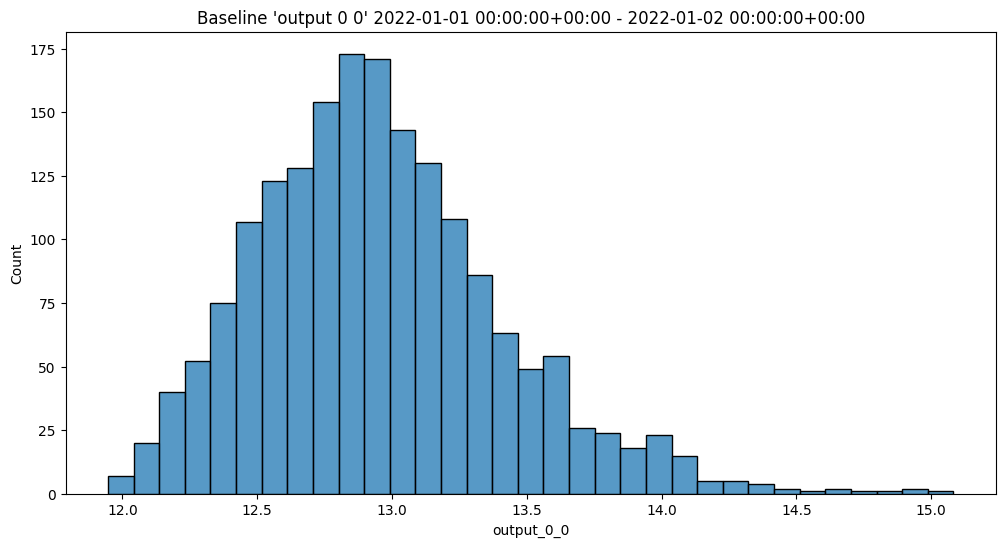

In [8]:
assay_builder.baseline_histogram()

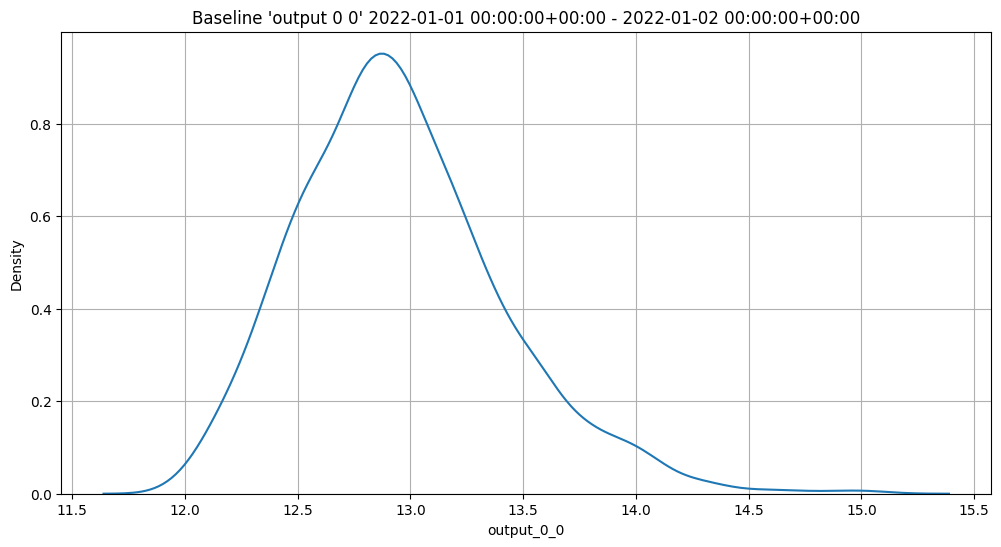

In [9]:
assay_builder.baseline_kde()

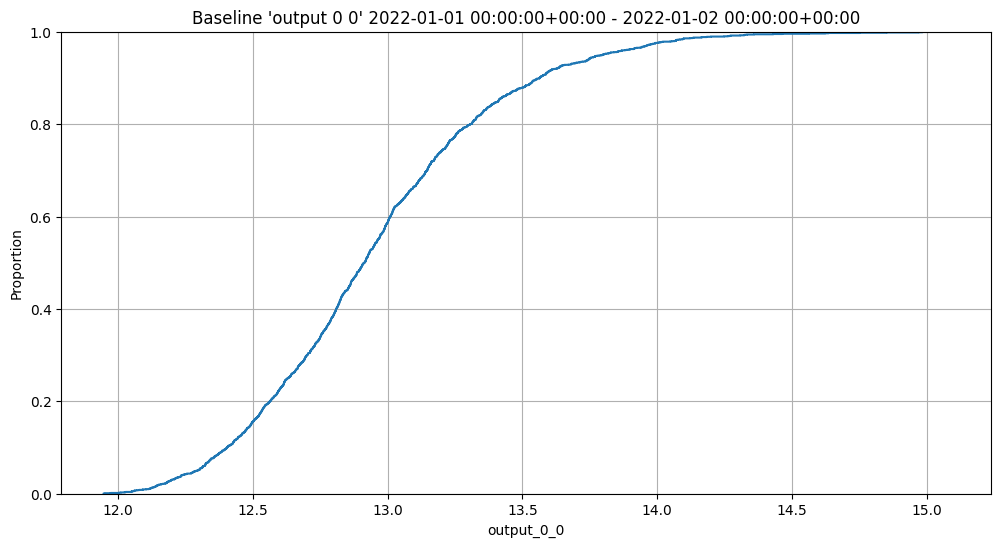

In [10]:
assay_builder.baseline_ecdf()

### Interactive Baseline Runs

We can do an interactive run of just the baseline part to see how the baseline data will be put into bins. This assay uses quintiles so all 5 bins (not counting the outlier bins) have 20% of the predictions. We can see the bin boundaries along the x-axis.

baseline mean = 12.954393170120568
baseline median = 12.913979530334473
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False


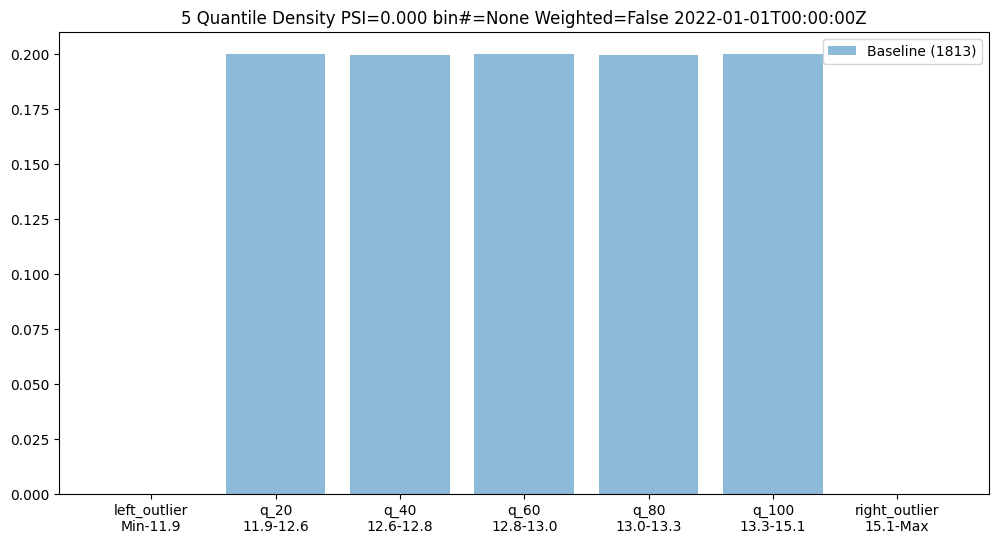

In [11]:
baseline_run.chart()

We can also get a dataframe with the bin/edge information.

In [12]:
baseline_run.baseline_bins()

,b_edges,b_edge_names,b_aggregated_values,b_aggregation
0,11.95,left_outlier,0.00,Density
1,12.56,q_20,0.20,Density
2,12.81,q_40,0.20,Density
3,13.01,q_60,0.20,Density
4,13.31,q_80,0.20,Density
5,15.08,q_100,0.20,Density
6,"179,769,313,486,231,570,814,527,423,731,704,356...",right_outlier,0.00,Density


The previous assay used quintiles so all of the bins had the same percentage/count of samples.  To get bins that are divided equally along the range of values we can use `BinMode.EQUAL`.

baseline mean = 12.954393170120568
baseline median = 12.913979530334473
bin_mode = Equal
aggregation = Density
metric = PSI
weighted = False


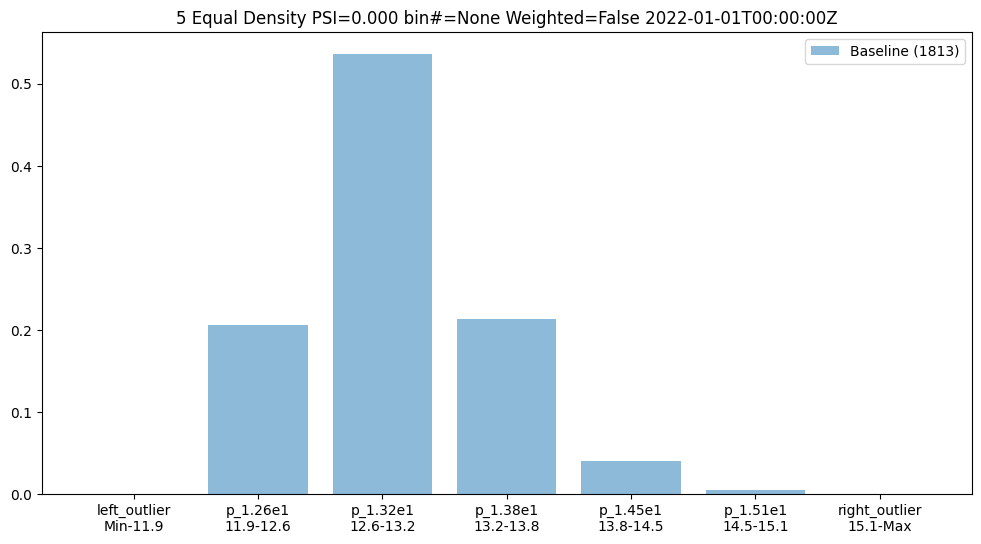

In [13]:
equal_bin_builder = client.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end)
equal_bin_builder.summarizer_builder.add_bin_mode(BinMode.EQUAL)
equal_baseline = equal_bin_builder.build().interactive_baseline_run()
equal_baseline.chart()

We now see very different bin edges and sample percentages per bin.

In [14]:
equal_baseline.baseline_bins()

,b_edges,b_edge_names,b_aggregated_values,b_aggregation
0,11.95,left_outlier,0.00,Density
1,12.57,p_1.26e1,0.21,Density
2,13.20,p_1.32e1,0.54,Density
3,13.83,p_1.38e1,0.21,Density
4,14.45,p_1.45e1,0.04,Density
5,15.08,p_1.51e1,0.00,Density
6,"179,769,313,486,231,570,814,527,423,731,704,356...",right_outlier,0.00,Density


### Interactive Assay Runs

By default the assay builder creates an assay with some good starting parameters. In particular the assay is configured to run a new analysis for **every 24 hours starting at the end of the baseline period**. Additionally, it sets the **number of bins to 5** to create quintiles, and sets the target `iopath` to `"outputs 0 0"` which means we want to monitor the first column of the first output/prediction.

We can do an interactive run of just the baseline part to see how the baseline data will be put into bins. This assay uses quintiles so all 5 bins (not counting the outlier bins) have 20% of the predictions. We can see the bin boundaries along the x-axis.

We then run it with `interactive_run` and convert it to a dataframe for easy analysis with `to_dataframe`.

Now let's do an interactive run of the first assay as it is configured.  Interactive runs don't save the assay to the database (so they won't be scheduled in the future) nor do they save the assay results. Instead the results are returned after a short while for further analysis.

#### Configuration Notes

By default the distance measure used is a modified version of the *Population Stability Index*, a measure that's widely used in banking and finance, and is also known as the *Jeffreys divergence*, or the *Symmetrised Kullback-Leibler divergence*.

There is a handy rule of thumb for determining whether the PSI score is "large":

* PSI < 0.1: The distance is small; the distributions are about the same
* 0.1 <= PSI < 0.2: The distance is moderately large; the distributions are somewhat different, and there may be some data drift
* PSI >= 0.2: The distance is large; the distributions are different. A prolonged range of PSI > 0.2 can indicate the model is no longer in operating bounds and should be retrained.

Of course, this is only a rule of thumb; different thresholds may work better for a specific application, and this exploration can help you properly tune the threshold (or other parameters, like the binning scheme or difference metric) as needed.

The red dots in the above graph indicate distance scores larger than our threshold of 0.1. We see that the difference scores are low for a while and then jump up to indicate there is an issue. We can examine that particular window to help us decide if that threshold is set correctly or not.

We can also retrieve the above results as a data frame, for further analysis, if desired.

In [15]:
assay_builder = client.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end)
assay_config = assay_builder.add_run_until(last_day).build()
assay_results = assay_config.interactive_run()
assay_df = assay_results.to_dataframe()
assay_df

,assay_id,name,iopath,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,None,example assay,output 0 0,0.01,2022-01-02T00:00:00Z,11.62,15.11,12.95,12.91,0.45,None,0.25,Ok
1,None,example assay,output 0 0,0.01,2022-01-03T00:00:00Z,11.87,15.39,12.95,12.90,0.45,None,0.25,Ok
2,None,example assay,output 0 0,0.00,2022-01-04T00:00:00Z,11.74,14.79,12.95,12.93,0.44,None,0.25,Ok
3,None,example assay,output 0 0,0.02,2022-01-05T00:00:00Z,11.89,15.81,12.95,12.92,0.44,None,0.25,Ok
4,None,example assay,output 0 0,0.01,2022-01-06T00:00:00Z,11.83,14.94,12.95,12.92,0.44,None,0.25,Ok
5,None,example assay,output 0 0,0.02,2022-01-07T00:00:00Z,11.83,15.14,12.96,12.92,0.44,None,0.25,Ok
6,None,example assay,output 0 0,0.01,2022-01-08T00:00:00Z,11.89,15.48,12.93,12.90,0.43,None,0.25,Ok
7,None,example assay,output 0 0,0.01,2022-01-09T00:00:00Z,11.80,15.12,12.95,12.91,0.45,None,0.25,Ok
8,None,example assay,output 0 0,0.01,2022-01-10T00:00:00Z,11.93,14.79,12.95,12.90,0.44,None,0.25,Ok
9,None,example assay,output 0 0,0.01,2022-01-11T00:00:00Z,11.86,14.81,12.96,12.93,0.44,None,0.25,Ok


Basic functionality for creating quick charts is included.

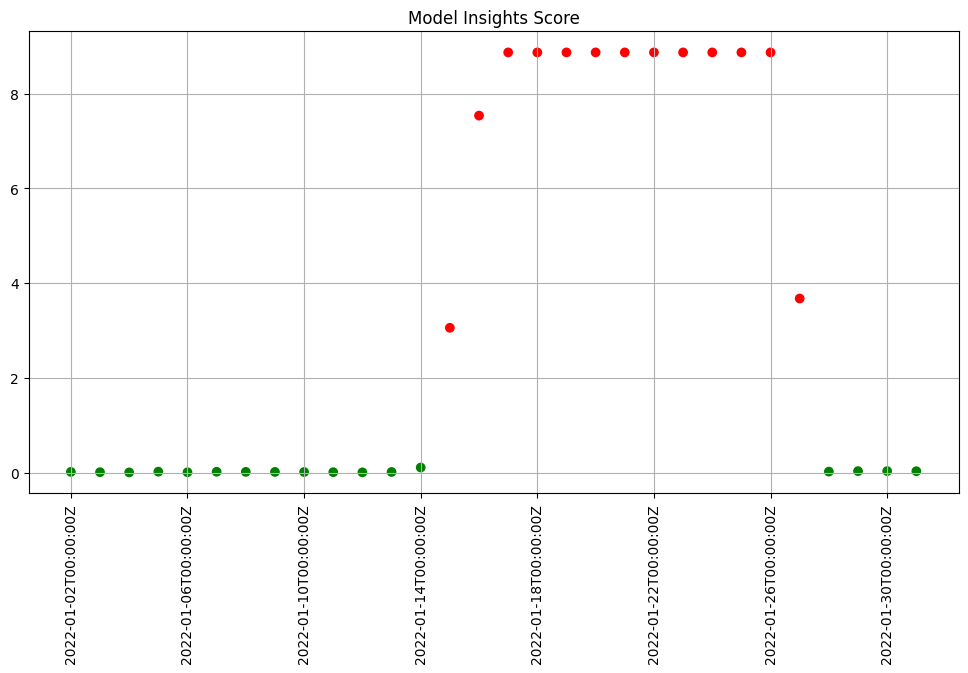

In [16]:
assay_results.chart_scores()

We see that the difference scores are low for a while and then jump up to indicate there is an issue. We can examine that particular window to help us decide if that threshold is set correctly or not.

We can generate a quick chart of the results. This chart shows the 5 quantile bins (quintiles) derived from the baseline data plus one for left outliers and one for right outliers.  We also see that the data from the window falls within the baseline quintiles but in a different proportion and is skewing higher. Whether this is an issue or not is specific to your use case.

First let's examine a day that is only slightly different than the baseline. We see that we do see some values that fall outside of the range from the baseline values, the left and right outliers, and that the bin values are different but similar.

baseline mean = 12.954393170120568
window mean = 12.952570220492534
baseline median = 12.913979530334473
window median = 12.905640125274658
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.013551035434377596
scores = [0.0006959467613300823, 0.0004941766212731371, 0.0003452027689633905, 0.0014095463411471284, 0.0007957390027837054, 7.341649894282799e-06, 0.00980308228898587]
index = None


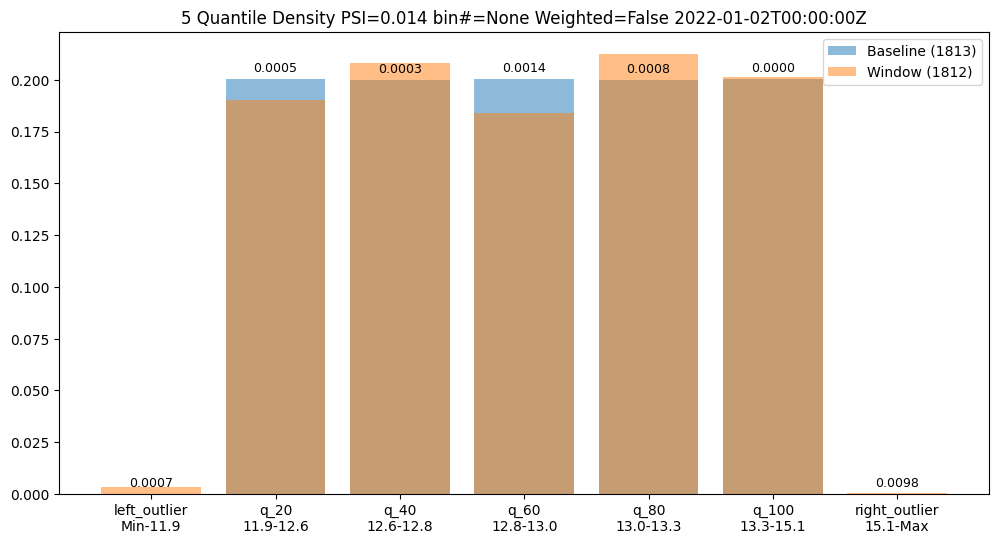

In [17]:
assay_results[0].chart()

Other days, however are significantly different.

baseline mean = 12.954393170120568
window mean = 13.018988957205092
baseline median = 12.913979530334473
window median = 12.995140552520752
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.1062324578888069
scores = [0.0, 0.06790765360198812, 0.0003893727578237944, 0.0037302373887164895, 0.02434412838052893, 5.798347076369716e-05, 0.00980308228898587]
index = None


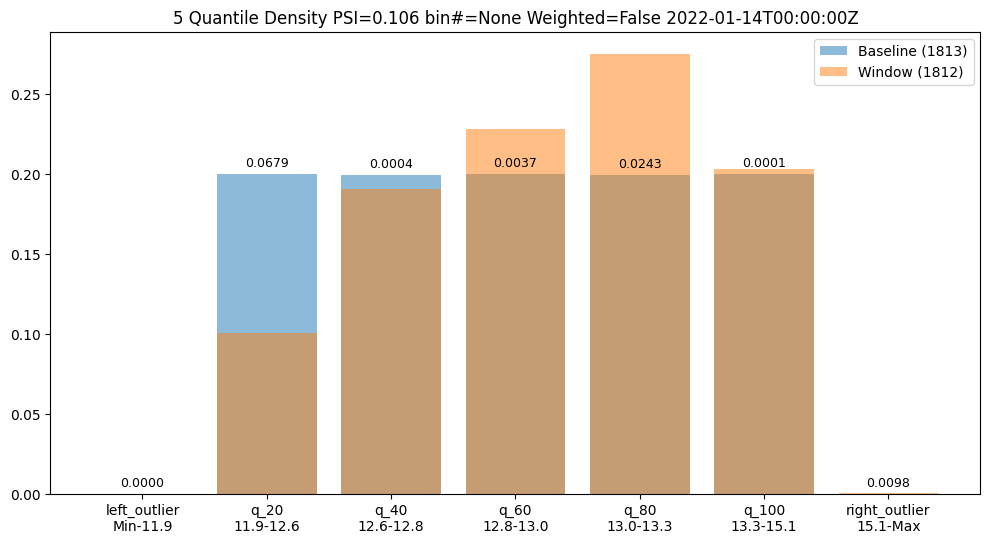

In [18]:
assay_results[12].chart()

baseline mean = 12.954393170120568
window mean = 14.013120903347765
baseline median = 12.913979530334473
window median = 13.991220951080322
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 3.055506158911697
scores = [0.0, 0.7203606043304971, 0.8049360069588025, 0.4504317335378006, 0.0820473282443674, 0.9698478211538909, 0.027882664686338928]
index = None


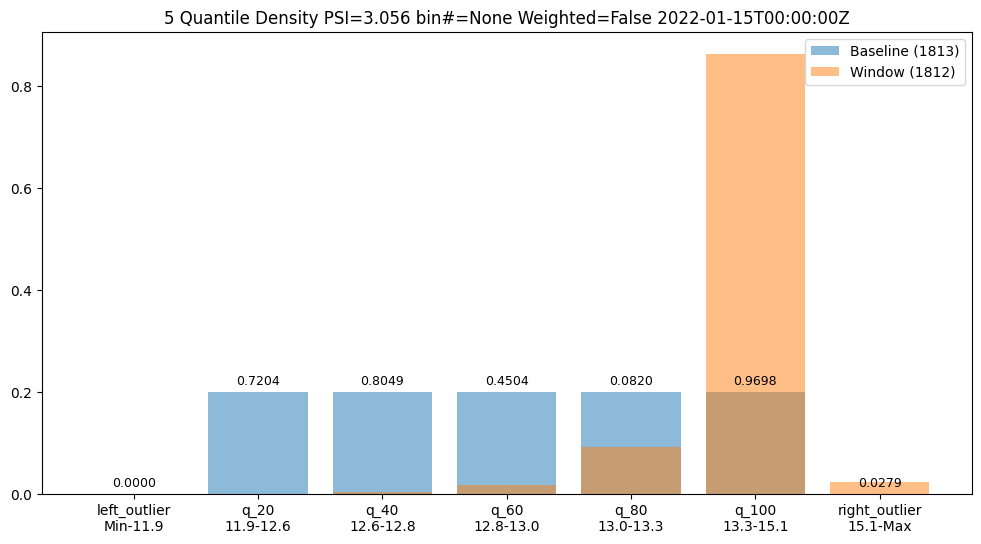

In [19]:
assay_results[13].chart()

If we want to investigate further, we can run interactive assays on each of the inputs to see if any of them show anything abnormal. In this example we'll provide the feature labels to create more understandable titles.

The current assay expects continuous data. Sometimes categorical data is encoded as 1 or 0 in a feature and sometimes in a limited number of values such as 1, 2, 3. If one value has high a percentage the analysis emits a warning so that we know the scores for that feature may not behave as we expect.

In [20]:
labels = ['bedrooms', 'bathrooms', 'lat', 'long', 'waterfront', 'sqft_living', 'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']

# get the raw inference logs
topic = client.get_topic_name(pipeline.id())
baseline_inferences = client.get_raw_pipeline_inference_logs(topic, baseline_start, baseline_end, model_name)

# feed the inference logs into the assay so we can examine the inputs
assay_results = assay_config.interactive_input_run(baseline_inferences, labels)
iadf = assay_results.to_dataframe()

input column distinct_vals label           largest_pct
    0     0             12 bedrooms        0.4567 
    0     1             26 bathrooms       0.2421 
    0     2           1492 lat             0.0022 
    0     3            502 long            0.0077 
    0     4              2 waterfront      0.9928 *** May not be continuous feature
    0     5            425 sqft_living     0.0094 
    0     6           1407 sqft_lot        0.0188 
    0     7              6 floors          0.5036 
    0     8              5 view            0.9068 *** May not be continuous feature
    0     9              5 condition       0.6293 
    0    10             10 grade           0.4242 
    0    11            393 sqft_above      0.0121 
    0    12            162 sqft_basement   0.6034 
    0    13            116 yr_built        0.0237 
    0    14             37 yr_renovated    0.9597 *** May not be continuous feature
    0    15            340 sqft_living15   0.0132 
    0    16           1347 sqf

We can chart each of the iopaths and do a visual inspection. From the charts we see that if any of the input features had significant differences in the first two days which we can choose to inspect further. Here we choose to show 3 charts just to save space in this notebook.

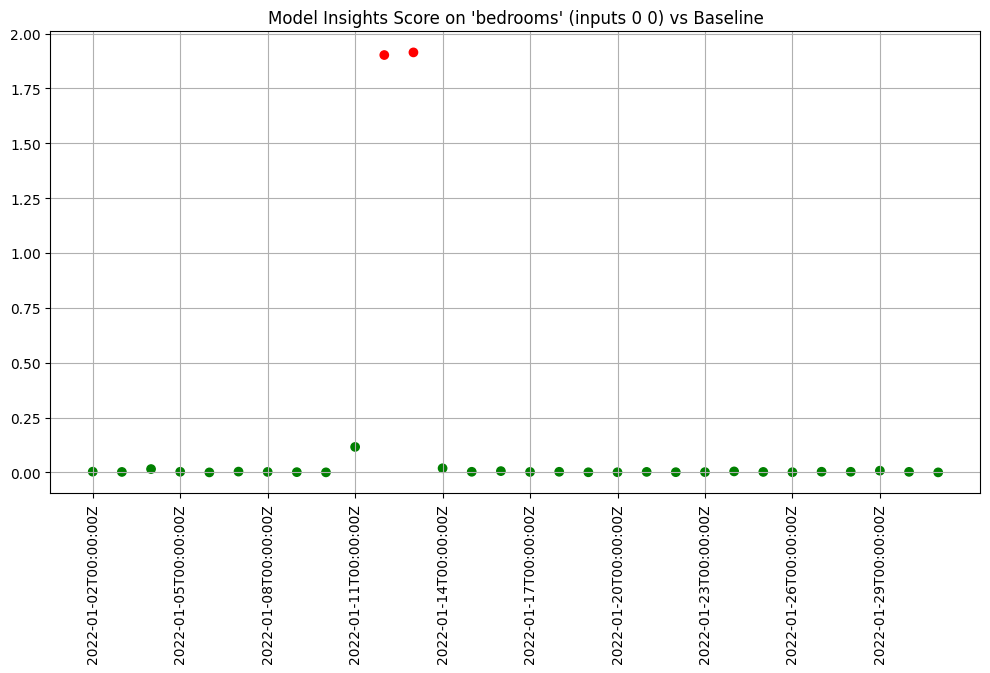

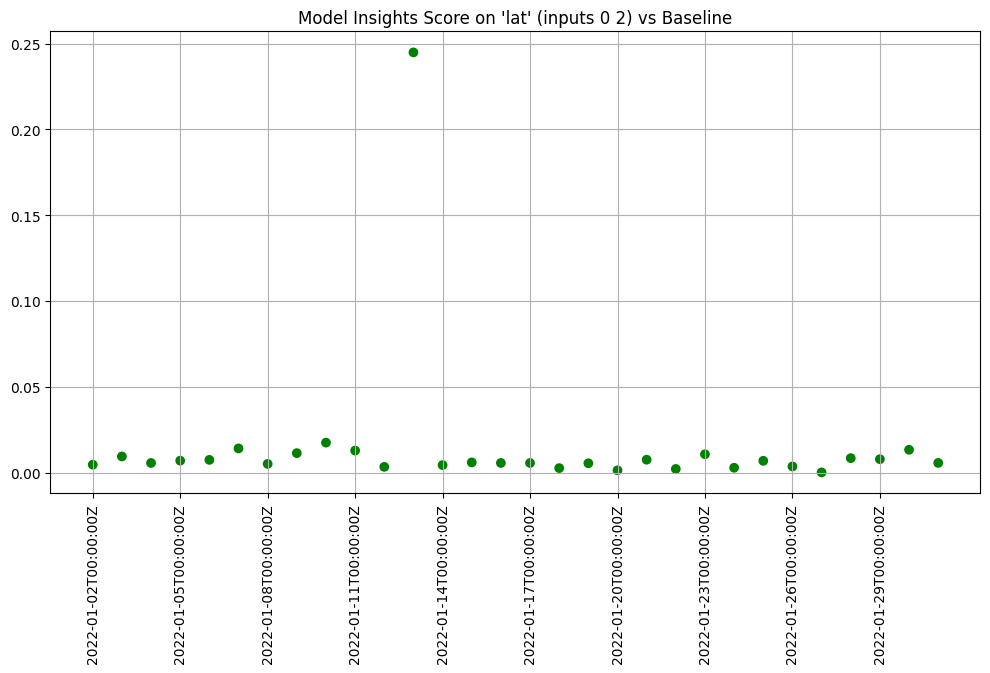

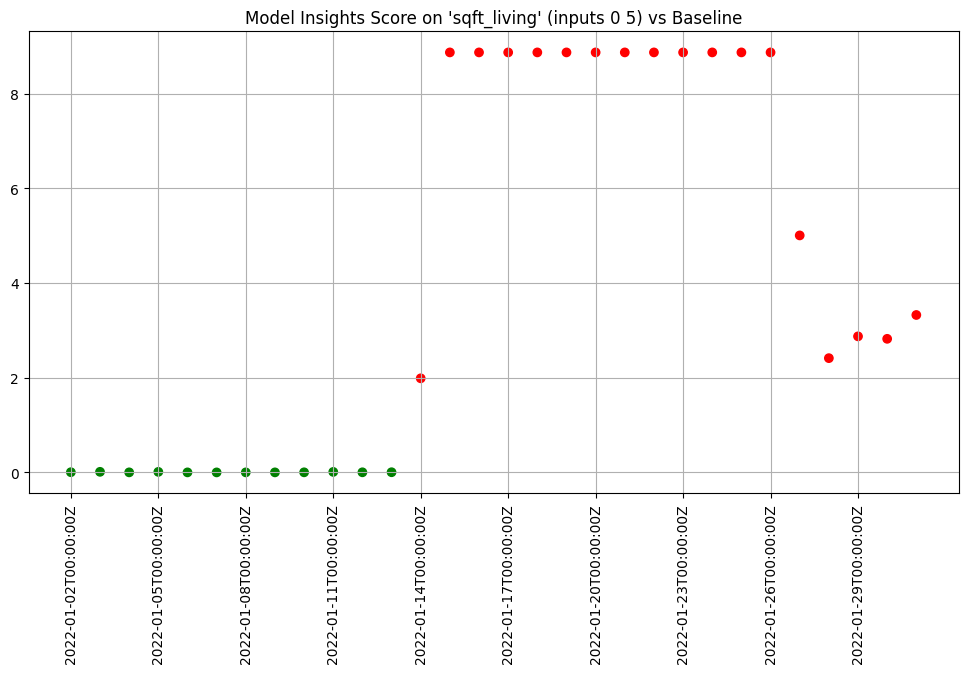

In [21]:
assay_results.chart_iopaths(labels=labels, selected_labels=['bedrooms', 'lat', 'sqft_living'])

When we are comfortable with what alert threshold should be for our specific purposes we can create and save an assay that will be automatically run on a daily basis.

In this example we're create an assay that runs everyday against the baseline and has an alert threshold of 0.5.

Once we upload it it will be saved and scheduled for future data as well as run against past data.

In [22]:
alert_threshold = 0.1
assay_builder = client.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end).add_alert_threshold(alert_threshold)
assay_id = assay_builder.upload()

To retrieve the results after enough time has passed, collect them with the method `get_assay_results_logs` specifying the time to collect and the `assay_id`.  This will take additional inference history so can not be demonstrated here, but the command to collect the data is listed below.

In [23]:
assay_results = client.get_assay_results_logs(baseline_end,datetime.datetime.now(), assay_id=assay_id)

## Schedule Assays

By default assays are scheduled to run **every 24 hours** starting immediately after the baseline period ends.

However, you can control the start time by setting `start` and the frequency by setting `interval` on the window.

So to recap:

* The window width is the **size** of the window. The default is 24 hours.
* The interval is:
  * How often the analysis is run.
  * How far the window is slid into the future based on the last run.
  * The default is the window width.
* The window start is when the analysis should start. The default is the end of the baseline period.

For example to run an analysis every 12 hours on the previous 24 hours of data, you'd set the window width to 24 (the default) and the interval to 12.

In [24]:
assay_builder = client.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end)
assay_builder = assay_builder.add_run_until(last_day)

assay_builder.window_builder().add_width(hours=24).add_interval(hours=12)

assay_config = assay_builder.build()

assay_results = assay_config.interactive_run()
print(f"Generated {len(assay_results)} analyses")

Generated 59 analyses


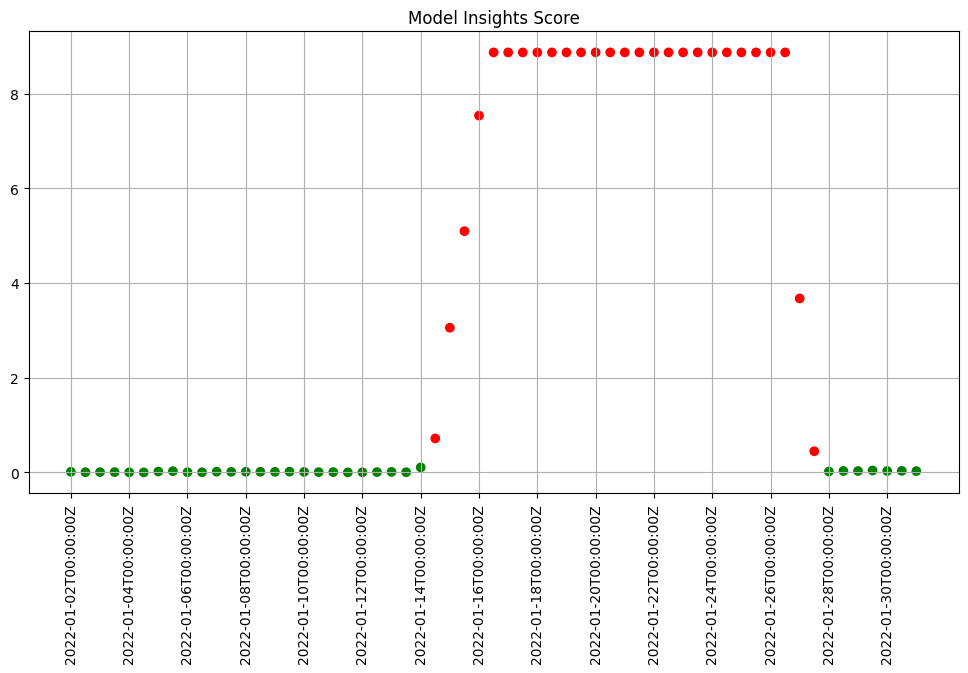

In [25]:
assay_results.chart_scores()

To start a weekly analysis of the previous week on a specific day, set the start date (taking care to specify the desired timezone), and the width and interval to 1 week.  The analysis will be generated when the window is complete.

In [26]:
report_start = datetime.datetime.fromisoformat('2022-01-03T00:00:00+00:00')

assay_builder = client.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end)
assay_builder = assay_builder.add_run_until(last_day)

assay_builder.window_builder().add_width(weeks=1).add_interval(weeks=1).add_start(report_start)

assay_config = assay_builder.build()

assay_results = assay_config.interactive_run()
print(f"Generated {len(assay_results)} analyses")

Generated 4 analyses


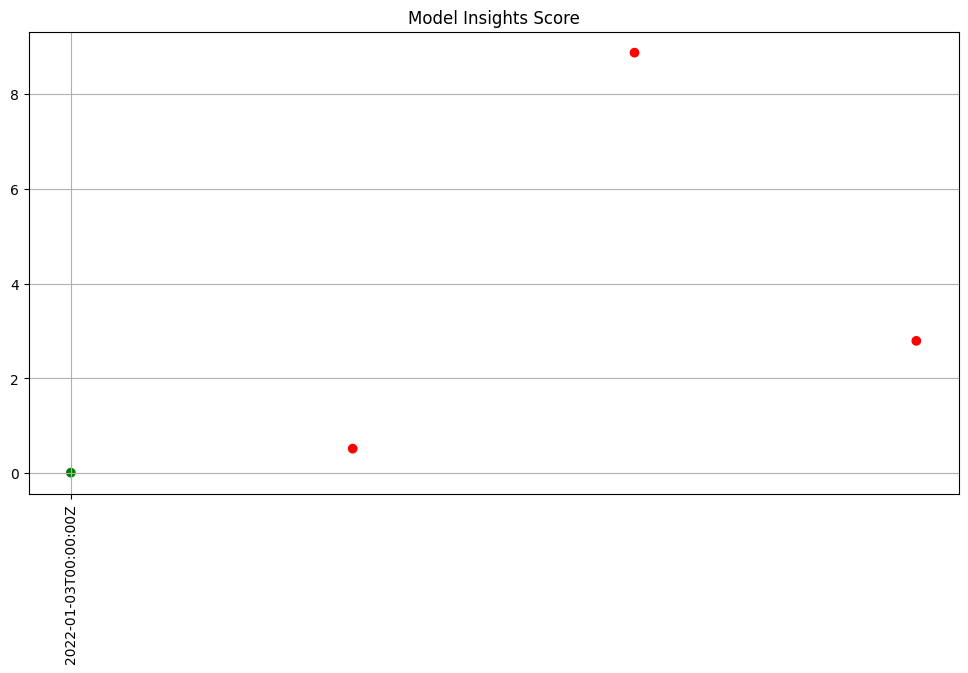

In [27]:
assay_results.chart_scores()

### Advanced Configuration

The assay can be configured in a variety of ways to help customize it to your particular needs. Specifically you can:
* change the `BinMode` to evenly spaced, quantile or user provided
* change the number of bins to use
* provide weights to use when scoring the bins
* calculate the score using the sum of differences, maximum difference or population stability index
* change the value aggregation for the bins to density, cumulative or edges

Let's take a look at these in turn.

#### Default configuration

First let's look at the default configuration. This is a lot of information but much of it is useful to know where it is available.

We see that the assay is broken up into 4 sections: 
  
* Top level meta data section
* Baseline specification
* Window specification
* The summarization configuration.

In the meta section we see the name of the assay, that it runs on the first column of the first output `"outputs 0 0"` and that there is a default threshold of 0.25.

The summarizer section shows us the defaults of Quantile, Density and PSI on 5 bins.

The baseline section shows us that it is configured as a fixed baseline with the specified start and end date times.

And the window tells us what model in the pipeline we are analyzing and how often.

In [28]:
assay_builder = client.build_assay("Test Assay", pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
print(assay_builder.build().to_json())

{
    "name": "Test Assay",
    "pipeline_id": 1,
    "pipeline_name": "housepricepipe",
    "active": true,
    "status": "created",
    "iopath": "output 0 0",
    "baseline": {
        "Fixed": {
            "pipeline": "housepricepipe",
            "model": "housepricemodel",
            "start_at": "2022-01-01T00:00:00+00:00",
            "end_at": "2022-01-02T00:00:00+00:00"
        }
    },
    "window": {
        "pipeline": "housepricepipe",
        "model": "housepricemodel",
        "width": "24 hours",
        "start": null,
        "interval": null
    },
    "summarizer": {
        "type": "UnivariateContinuous",
        "bin_mode": "Quantile",
        "aggregation": "Density",
        "metric": "PSI",
        "num_bins": 5,
        "bin_weights": null,
        "bin_width": null,
        "provided_edges": null,
        "add_outlier_edges": true
    },
    "warning_threshold": null,
    "alert_threshold": 0.25,
    "next_run": "2022-01-02T00:00:00+00:00",
    "run_until": 

#### Defaults

We can run the assay interactively and review the first analysis. The method `compare_basic_stats` gives us a dataframe with basic stats for the baseline and window data.

In [29]:
assay_results = assay_builder.build().interactive_run()
ar = assay_results[0]

ar.compare_basic_stats()

,Baseline,Window,diff,pct_diff
count,"1,813.00","1,812.00",-1.00,-0.06
min,11.95,11.62,-0.33,-2.72
max,15.08,15.11,0.03,0.17
mean,12.95,12.95,-0.00,-0.01
median,12.91,12.91,-0.01,-0.06
std,0.46,0.45,-0.01,-2.75
start,2022-01-01T00:00:00Z,2022-01-02T00:00:00Z,NaN,NaN
end,2022-01-02T00:00:00Z,2022-01-03T00:00:00Z,NaN,NaN


The method `compare_bins` gives us a dataframe with the bin information. Such as the number of bins, the right edges, suggested bin/edge names and the values for each bin in the baseline and the window.

In [30]:
ar.compare_bins()

,b_edges,b_edge_names,b_aggregated_values,b_aggregation,w_edges,w_edge_names,w_aggregated_values,w_aggregation,diff_in_pcts
0,11.95,left_outlier,0.00,Density,11.95,left_outlier,0.00,Density,0.00
1,12.56,q_20,0.20,Density,12.56,e_1.26e1,0.19,Density,-0.01
2,12.81,q_40,0.20,Density,12.81,e_1.28e1,0.21,Density,0.01
3,13.01,q_60,0.20,Density,13.01,e_1.30e1,0.18,Density,-0.02
4,13.31,q_80,0.20,Density,13.31,e_1.33e1,0.21,Density,0.01
5,15.08,q_100,0.20,Density,15.08,e_1.51e1,0.20,Density,0.00
6,"179,769,313,486,231,570,814,527,423,731,704,356...",right_outlier,0.00,Density,"179,769,313,486,231,570,814,527,423,731,704,356...",right_outlier,0.00,Density,0.00


We can also plot the chart to visualize the values of the bins.

baseline mean = 12.954393170120568
window mean = 12.952570220492534
baseline median = 12.913979530334473
window median = 12.905640125274658
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.013551035434377596
scores = [0.0006959467613300823, 0.0004941766212731371, 0.0003452027689633905, 0.0014095463411471284, 0.0007957390027837054, 7.341649894282799e-06, 0.00980308228898587]
index = None


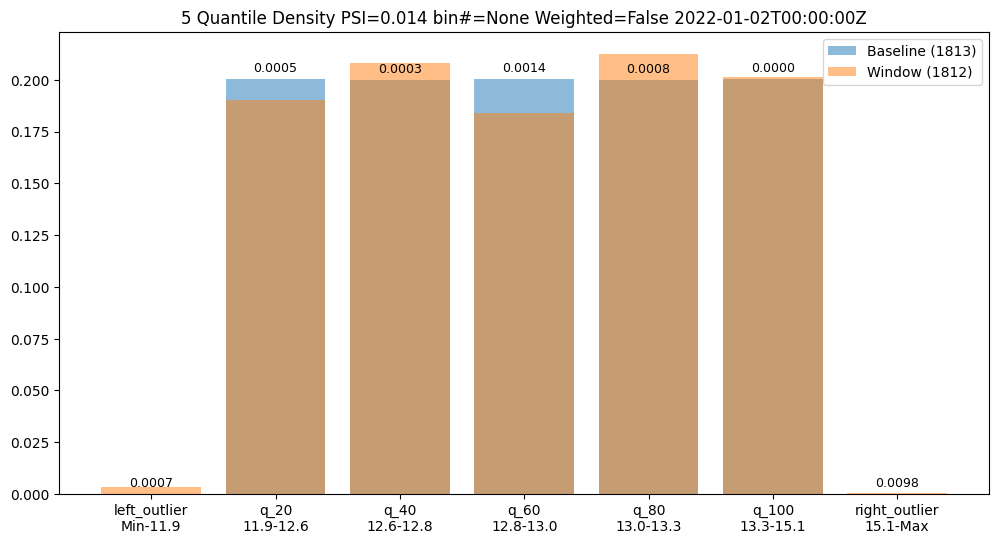

In [31]:
ar.chart()

#### Binning Mode

We can change the bin mode algorithm to equal and see that the bins/edges are partitioned at different points and the bins have different values.

,b_edges,b_edge_names,b_aggregated_values,b_aggregation,w_edges,w_edge_names,w_aggregated_values,w_aggregation,diff_in_pcts
0,11.95,left_outlier,0.00,Density,11.95,left_outlier,0.00,Density,0.00
1,12.57,p_1.26e1,0.21,Density,12.57,e_1.26e1,0.20,Density,-0.01
2,13.20,p_1.32e1,0.54,Density,13.20,e_1.32e1,0.53,Density,-0.01
3,13.83,p_1.38e1,0.21,Density,13.83,e_1.38e1,0.24,Density,0.02
4,14.45,p_1.45e1,0.04,Density,14.45,e_1.45e1,0.03,Density,-0.01
5,15.08,p_1.51e1,0.00,Density,15.08,e_1.51e1,0.00,Density,-0.00
6,"179,769,313,486,231,570,814,527,423,731,704,356...",right_outlier,0.00,Density,"179,769,313,486,231,570,814,527,423,731,704,356...",right_outlier,0.00,Density,0.00


None

baseline mean = 12.954393170120568
window mean = 12.952570220492534
baseline median = 12.913979530334473
window median = 12.905640125274658
bin_mode = Equal
aggregation = Density
metric = PSI
weighted = False
score = 0.016463316496701866
scores = [0.0006959467613300823, 0.00028622745636607417, 0.000136940329536975, 0.0024190313632530313, 0.0028459952590805006, 0.0002760930381493355, 0.00980308228898587]
index = None


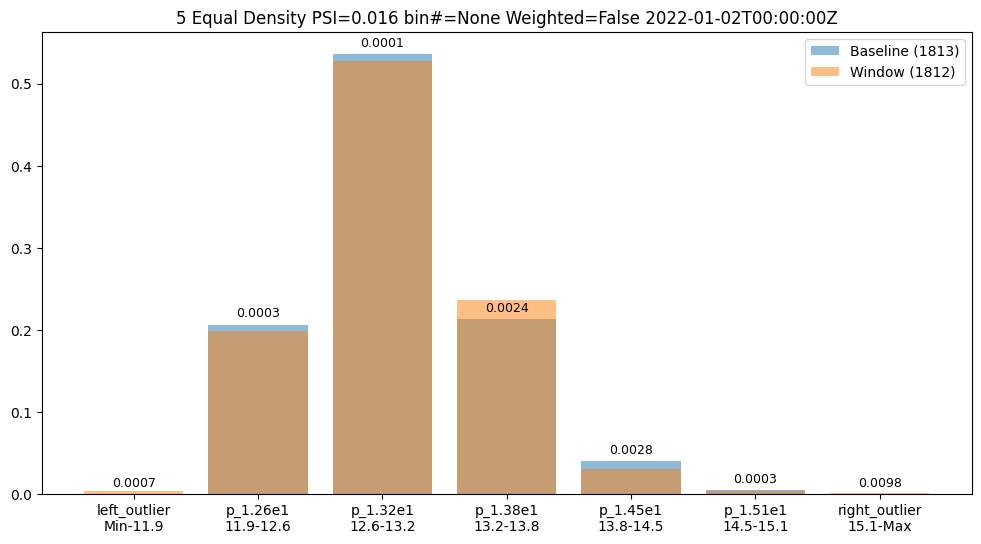

In [32]:
assay_builder = client.build_assay("Test Assay", pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_builder.summarizer_builder.add_bin_mode(BinMode.EQUAL)
assay_results = assay_builder.build().interactive_run()
display(display(assay_results[0].compare_bins()))
assay_results[0].chart()

#### User Provided Bin Edges

The values in this dataset run from ~11.6 to ~15.81. And let's say we had a business reason to use specific bin edges.  We can specify them with the BinMode.PROVIDED and specifying a list of floats with the right hand / upper edge of each bin and optionally the lower edge of the smallest bin. If the lowest edge is not specified the threshold for left outliers is taken from the smallest value in the baseline dataset.

,b_edges,b_edge_names,b_aggregated_values,b_aggregation,w_edges,w_edge_names,w_aggregated_values,w_aggregation,diff_in_pcts
0,11.00,left_outlier,0.00,Density,11.00,left_outlier,0.00,Density,0.00
1,12.00,e_1.20e1,0.00,Density,12.00,e_1.20e1,0.00,Density,0.00
2,13.00,e_1.30e1,0.59,Density,13.00,e_1.30e1,0.58,Density,-0.01
3,14.00,e_1.40e1,0.39,Density,14.00,e_1.40e1,0.40,Density,0.01
4,15.00,e_1.50e1,0.02,Density,15.00,e_1.50e1,0.02,Density,-0.01
5,16.00,e_1.60e1,0.00,Density,16.00,e_1.60e1,0.00,Density,0.00
6,"179,769,313,486,231,570,814,527,423,731,704,356...",right_outlier,0.00,Density,"179,769,313,486,231,570,814,527,423,731,704,356...",right_outlier,0.00,Density,0.00


None

baseline mean = 12.954393170120568
window mean = 12.952570220492534
baseline median = 12.913979530334473
window median = 12.905640125274658
bin_mode = Provided
aggregation = Density
metric = PSI
weighted = False
score = 0.005831639113611392
scores = [0.0, 0.002708901099649454, 0.00015914496208737885, 0.0004215024577886459, 0.002159043392325224, 0.00038304720176068804, 0.0]
index = None


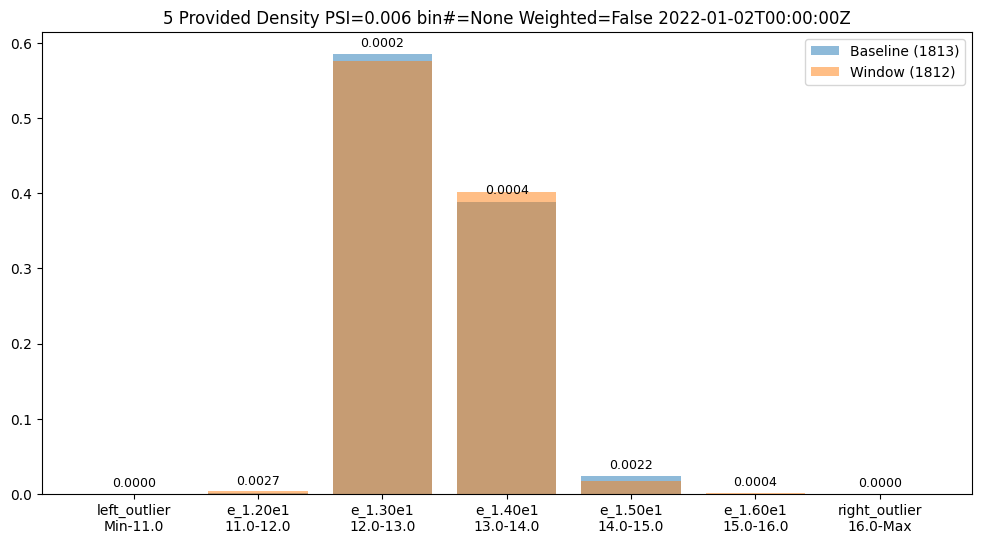

In [33]:
edges = [11.0, 12.0, 13.0, 14.0, 15.0, 16.0]
assay_builder = client.build_assay("Test Assay", pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_builder.summarizer_builder.add_bin_mode(BinMode.PROVIDED, edges)
assay_results = assay_builder.build().interactive_run()
display(display(assay_results[0].compare_bins()))
assay_results[0].chart()

#### Number of Bins

We could also choose to a different number of bins, let's say 10, which can be evenly spaced or based on the quantiles (deciles).

,b_edges,b_edge_names,b_aggregated_values,b_aggregation,w_edges,w_edge_names,w_aggregated_values,w_aggregation,diff_in_pcts
0,11.95,left_outlier,0.00,Density,11.95,left_outlier,0.00,Density,0.00
1,12.40,q_10,0.10,Density,12.40,e_1.24e1,0.10,Density,0.00
2,12.56,q_20,0.10,Density,12.56,e_1.26e1,0.09,Density,-0.01
3,12.70,q_30,0.10,Density,12.70,e_1.27e1,0.09,Density,-0.01
4,12.81,q_40,0.10,Density,12.81,e_1.28e1,0.10,Density,0.00
5,12.91,q_50,0.10,Density,12.91,e_1.29e1,0.12,Density,0.02
6,13.01,q_60,0.10,Density,13.01,e_1.30e1,0.08,Density,-0.02
7,13.15,q_70,0.10,Density,13.15,e_1.31e1,0.12,Density,0.02
8,13.31,q_80,0.10,Density,13.31,e_1.33e1,0.09,Density,-0.01
9,13.56,q_90,0.10,Density,13.56,e_1.36e1,0.11,Density,0.01


None

baseline mean = 12.954393170120568
window mean = 12.94535461693147
baseline median = 12.913979530334473
window median = 12.903773307800293
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.021364617672033626
scores = [0.0013318933239185415, 0.0001508387888967812, 0.0014077319940240033, 0.00044689056669365687, 0.0001508387888967812, 0.002879132738274895, 0.002579185308688176, 0.002722796821458902, 0.0011510010089298668, 0.0009475972030849906, 0.001710564941068633, 0.005886146188098397]
index = None


/opt/conda/lib/python3.8/site-packages/wallaroo/assay.py:325: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=edge_names, rotation=45)


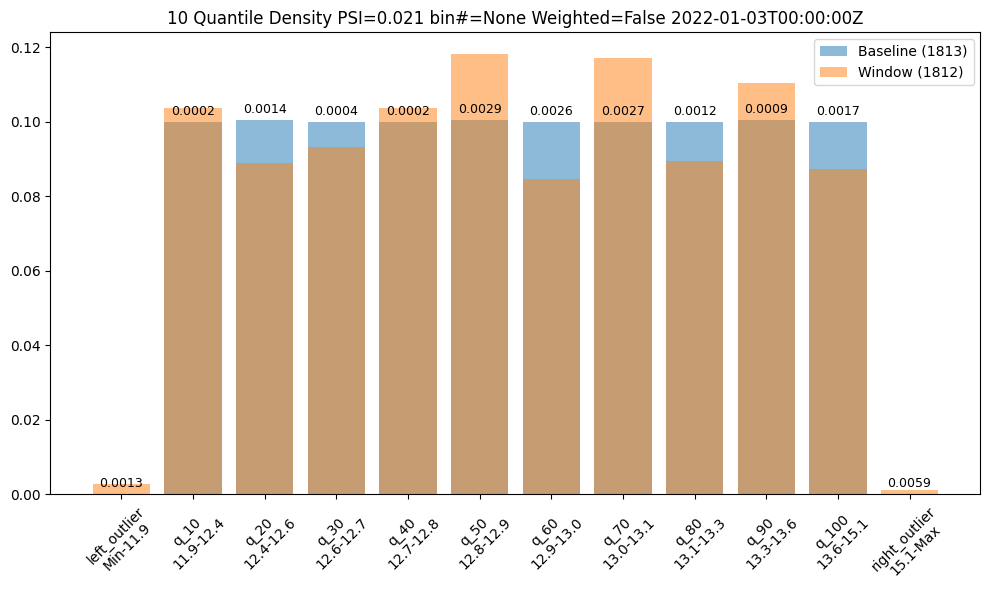

In [34]:
assay_builder = client.build_assay("Test Assay", pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_builder.summarizer_builder.add_bin_mode(BinMode.QUANTILE).add_num_bins(10)
assay_results = assay_builder.build().interactive_run()
display(display(assay_results[1].compare_bins()))
assay_results[1].chart()

#### Bin Weights

Now let's say we only care about differences at the higher end of the range. We can use weights to specify that difference in the lower bins should not be counted in the score. 

If we stick with 10 bins we can provide 10 a vector of 12 weights. One weight each for the original bins plus one at the front for the left outlier bin and one at the end for the right outlier bin.

Note we still show the values for the bins but the scores for the lower 5 and left outlier are 0 and only the right half is counted and reflected in the score.

Using weights:  [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]


,b_edges,b_edge_names,b_aggregated_values,b_aggregation,w_edges,w_edge_names,w_aggregated_values,w_aggregation,diff_in_pcts
0,11.95,left_outlier,0.00,Density,11.95,left_outlier,0.00,Density,0.00
1,12.40,q_10,0.10,Density,12.40,e_1.24e1,0.10,Density,0.00
2,12.56,q_20,0.10,Density,12.56,e_1.26e1,0.09,Density,-0.01
3,12.70,q_30,0.10,Density,12.70,e_1.27e1,0.09,Density,-0.01
4,12.81,q_40,0.10,Density,12.81,e_1.28e1,0.10,Density,0.00
5,12.91,q_50,0.10,Density,12.91,e_1.29e1,0.12,Density,0.02
6,13.01,q_60,0.10,Density,13.01,e_1.30e1,0.08,Density,-0.02
7,13.15,q_70,0.10,Density,13.15,e_1.31e1,0.12,Density,0.02
8,13.31,q_80,0.10,Density,13.31,e_1.33e1,0.09,Density,-0.01
9,13.56,q_90,0.10,Density,13.56,e_1.36e1,0.11,Density,0.01


None

baseline mean = 12.954393170120568
window mean = 12.94535461693147
baseline median = 12.913979530334473
window median = 12.903773307800293
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = True
score = 0.0024995485785548276
scores = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000429864218114696, 0.00045379947024315036, 0.00019183350148831114, 0.00015793286718083176, 0.0002850941568447722, 0.0009810243646830661]
index = None


/opt/conda/lib/python3.8/site-packages/wallaroo/assay.py:325: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=edge_names, rotation=45)


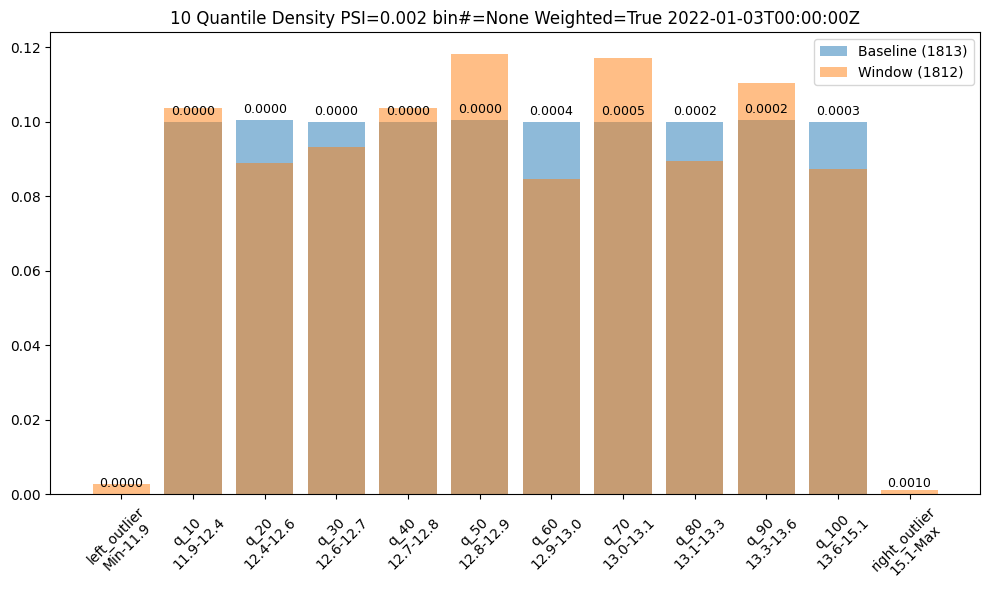

In [35]:
weights = [0] * 6
weights.extend([1] * 6)
print("Using weights: ", weights)
assay_builder = client.build_assay("Test Assay", pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_builder.summarizer_builder.add_bin_mode(BinMode.QUANTILE).add_num_bins(10).add_bin_weights(weights)
assay_results = assay_builder.build().interactive_run()
display(display(assay_results[1].compare_bins()))
assay_results[1].chart()

#### Metrics

The `score` is a distance or dis-similarity measure. The larger it is the less similar the two distributions are. We currently support
summing the differences of each individual bin, taking the maximum difference and a modified Population Stability Index (PSI).

The following three charts use each of the metrics. Note how the scores change. The best one will depend on your particular use case.

baseline mean = 12.954393170120568
window mean = 12.952570220492534
baseline median = 12.913979530334473
window median = 12.905640125274658
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.013551035434377596
scores = [0.0006959467613300823, 0.0004941766212731371, 0.0003452027689633905, 0.0014095463411471284, 0.0007957390027837054, 7.341649894282799e-06, 0.00980308228898587]
index = None


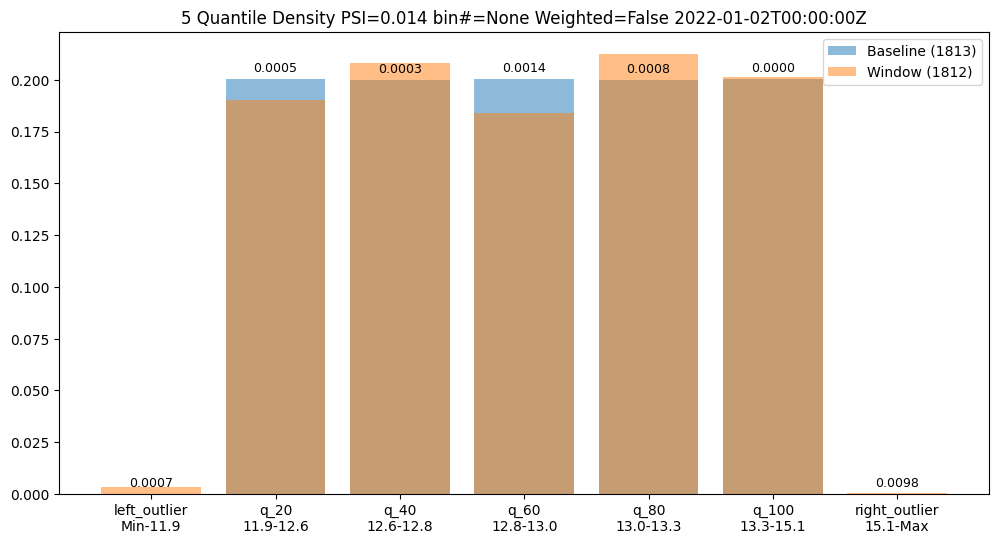

In [36]:
assay_builder = client.build_assay("Test Assay", pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_results = assay_builder.build().interactive_run()
assay_results[0].chart()

baseline mean = 12.954393170120568
window mean = 12.952570220492534
baseline median = 12.913979530334473
window median = 12.905640125274658
bin_mode = Quantile
aggregation = Density
metric = SumDiff
weighted = False
score = 0.02626907215365116
scores = [0.0033112582781456954, 0.009823277798679891, 0.008388338331573902, 0.016445794354971288, 0.012803349369101491, 0.001214249795139094, 0.0005518763796909492]
index = None


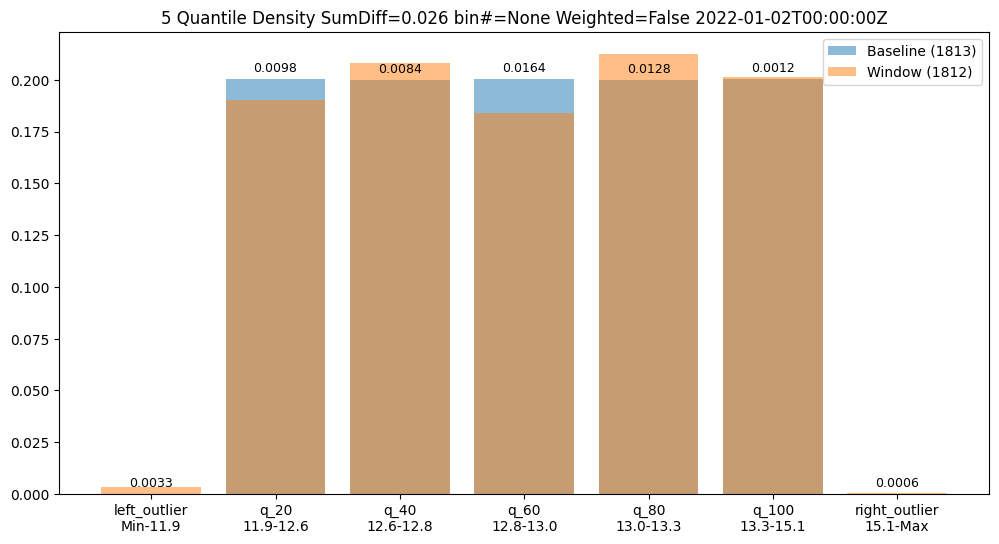

In [37]:
assay_builder = client.build_assay("Test Assay", pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_builder.summarizer_builder.add_metric(Metric.SUMDIFF)
assay_results = assay_builder.build().interactive_run()
assay_results[0].chart()

baseline mean = 12.954393170120568
window mean = 12.952570220492534
baseline median = 12.913979530334473
window median = 12.905640125274658
bin_mode = Quantile
aggregation = Density
metric = MaxDiff
weighted = False
score = 0.016445794354971288
scores = [0.0033112582781456954, 0.009823277798679891, 0.008388338331573902, 0.016445794354971288, 0.012803349369101491, 0.001214249795139094, 0.0005518763796909492]
index = 3


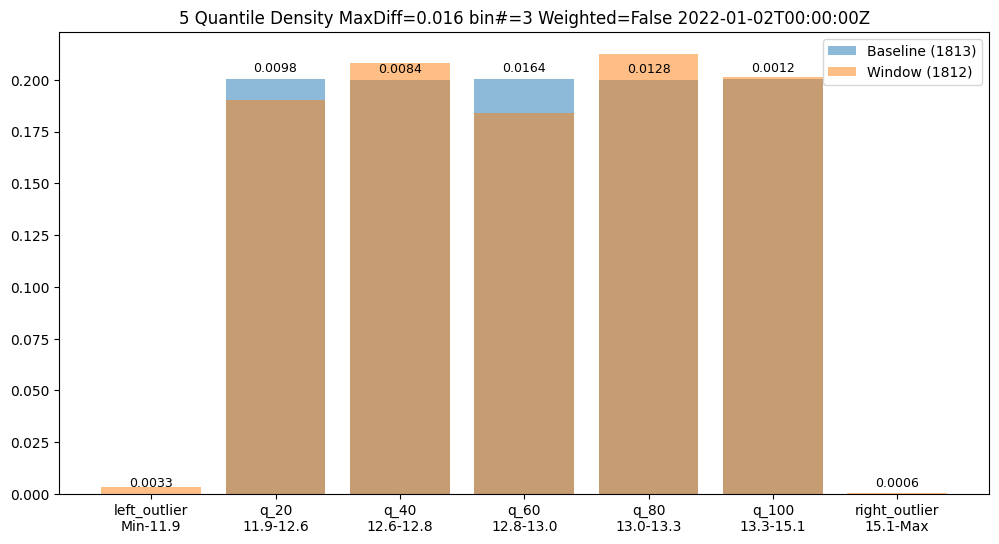

In [38]:
assay_builder = client.build_assay("Test Assay", pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_builder.summarizer_builder.add_metric(Metric.MAXDIFF)
assay_results = assay_builder.build().interactive_run()
assay_results[0].chart()

#### Aggregation Options

Also, bin aggregation can be done in histogram `Aggregation.DENSITY` style (the default) where we count the number/percentage of values that fall in each bin or Empirical Cumulative Density Function style `Aggregation.CUMULATIVE` where we keep a cumulative count of the values/percentages that fall in each bin.

baseline mean = 12.954393170120568
window mean = 12.952570220492534
baseline median = 12.913979530334473
window median = 12.905640125274658
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.013551035434377596
scores = [0.0006959467613300823, 0.0004941766212731371, 0.0003452027689633905, 0.0014095463411471284, 0.0007957390027837054, 7.341649894282799e-06, 0.00980308228898587]
index = None


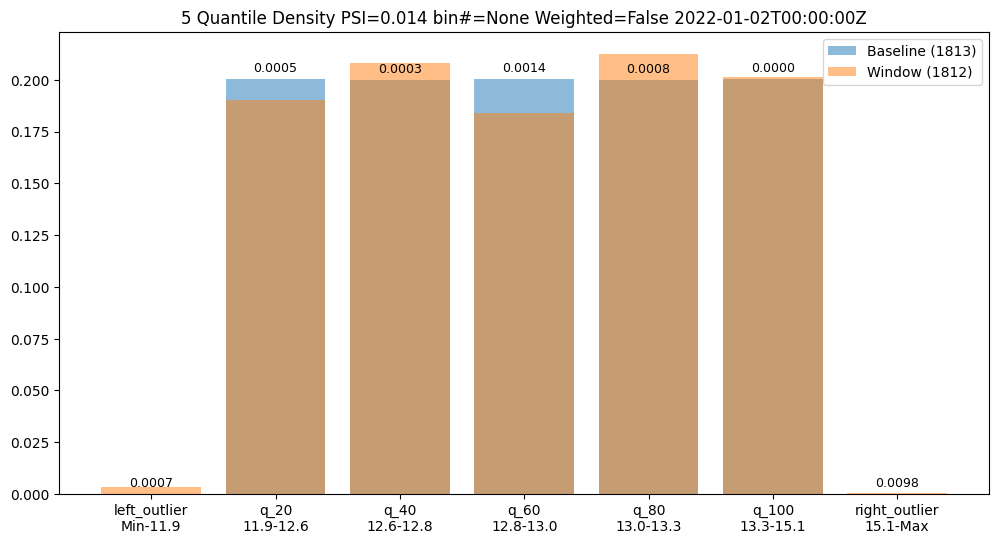

In [39]:
assay_builder = client.build_assay("Test Assay", pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_builder.summarizer_builder.add_aggregation(Aggregation.DENSITY)
assay_results = assay_builder.build().interactive_run()
assay_results[0].chart()

baseline mean = 12.954393170120568
window mean = 12.952570220492534
baseline median = 12.913979530334473
window median = 12.905640125274658
bin_mode = Quantile
aggregation = Cumulative
metric = PSI
weighted = False
score = 0.028587074708172105
scores = [0.0033112582781456954, 0.006512019520534207, 0.0018763188110397233, 0.01456947554393151, 0.0017661261748300738, 0.0005518763796908965, 0.0]
index = None


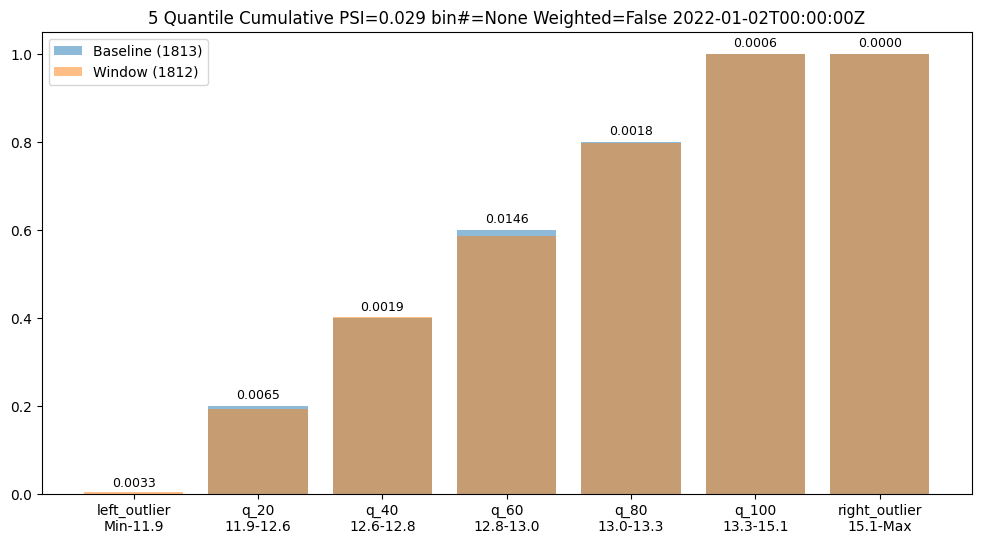

In [40]:
assay_builder = client.build_assay("Test Assay", pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_builder.summarizer_builder.add_aggregation(Aggregation.CUMULATIVE)
assay_results = assay_builder.build().interactive_run()
assay_results[0].chart()